In [1]:
import os, pickle, sys
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import glob
from prettytable import PrettyTable
from tqdm import tqdm

In [4]:
t=None
all_ds = {}
all_acc = {}
allc = {}
all_metrics = {}
all_runs = {}
metric_names = ['grad_norm', 'snip', 'grasp', 'fisher', 'synflow', 'jacob_cov']
for fname,rname in [('../mytest/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','CIFAR10')]:
    runs=[]
    f = open(fname,'rb')
    while(1):
        try:
            runs.append(pickle.load(f))
        except EOFError:
            break
    f.close()
    print(fname, len(runs))
    print(runs[0])
    
    all_runs[fname]=runs
    all_ds[fname] = {}
    metrics={}
    for k in metric_names:
        metrics[k] = []
    acc = []
    
    if t is None:
        hl=['Dataset']
        hl.extend(metric_names)
        t = PrettyTable(hl)
    
    for r in runs:
        for k,v in r['logmeasures'].items():
            if k in metrics:
                metrics[k].append(v)
        acc.append(r['testacc'])
        
    all_ds[fname]['metrics'] = metrics
    all_ds[fname]['acc'] = acc

    res = []
    crs = {}
    for k in hl:
        if k=='Dataset':
            continue
        v = metrics[k]
        print(k)
        cr = abs(stats.spearmanr(acc,v,nan_policy='omit').correlation)
        #print(f'{k} = {cr}')
        res.append(round(cr,3))
        crs[k]=cr
    
    ds = rname
    all_acc[ds]=acc
    allc[ds]=crs
    t.add_row([ds]+res)
      
    all_metrics[ds] = metrics
print(t)

../mytest/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p 15625
{'i': 0, 'arch': '|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|', 'logmeasures': {'grad_norm': 3.0226049423217773, 'snip': 4.861328125, 'grasp': -0.23073410987854004, 'fisher': 0.004737270530313253, 'jacob_cov': -139.65288101980764, 'plain': 0.1716836839914322, 'synflow_bn': 16.958625703888945, 'synflow': 0.0}, 'trainacc': 88.91866665852865, 'valacc': 81.98266665690103, 'testacc': 81.52}
grad_norm
snip
grasp
fisher
synflow
jacob_cov
+---------+-----------+-------+-------+--------+---------+-----------+
| Dataset | grad_norm |  snip | grasp | fisher | synflow | jacob_cov |
+---------+-----------+-------+-------+--------+---------+-----------+
| CIFAR10 |   0.595   | 0.596 | 0.519 | 0.361  |  0.161  |   0.728   |
+---------+-----------+-------+-------+--------+---------+-----------+


In [13]:
print (all_acc)

{'CIFAR10': [81.52, 90.51333333333332, 81.83999999999999, 83.88333333333334, 84.49666666666667, 87.78000000000002, 88.64666666666666, 88.77333333333333, 88.81, 84.11666666666666, 10.0, 87.64999999999999, 10.0, 87.83666666666666, 88.3, 56.19333333333333, 89.90333333333332, 86.19666666666667, 87.44666666666667, 84.35666666666667, 86.92666666666666, 89.14, 85.79333333333334, 86.14999999999999, 81.62333333333332, 83.87666666666667, 86.94333333333334, 86.55000000000001, 82.7, 84.46, 88.51333333333334, 87.14666666666666, 89.07666666666665, 88.14666666666666, 88.22333333333334, 87.67, 87.39333333333333, 86.55000000000001, 88.49333333333334, 86.70666666666666, 71.41333333333334, 85.72000000000001, 90.64333333333333, 88.37, 75.18666666666667, 86.47666666666667, 86.88333333333333, 86.71999999999998, 82.67666666666668, 87.78333333333335, 89.62333333333333, 85.27666666666666, 90.29333333333334, 34.196666666666665, 87.28666666666668, 84.14666666666666, 90.04666666666667, 71.65666666666665, 59.53666

In [64]:
from tqdm import tqdm
votes = {}
def vote(mets, gt):
    numpos = 0
    for m in mets:
        numpos += 1 if m > 0 else 0
    if numpos >= len(mets)/2:
        sign = +1
    else:
        sign = -1
    return sign*gt

for ds in all_acc.keys():
    num_pts = 15625
    #num_pts = 1000
    tot=0
    right=0
    #i比j好，用synflow,jacob_cov,snip投票，如果i比j好占绝对多数，则right+=1
    for i in tqdm(range(num_pts)):
        for j in range(num_pts):
            if i!=j:
                diff = all_acc[ds][i] - all_acc[ds][j]
                if diff == 0:
                    continue
                diffsyn = []
                for m in ['synflow', 'jacob_cov', 'snip', 'grad_norm']:
                    diffsyn.append(all_metrics[ds][m][i] - all_metrics[ds][m][j])
                same_sign = vote(diffsyn, diff)
                right += 1 if same_sign > 0 else 0
                tot += 1
    votes[ds.lower() if 'CIFAR' in ds else ds] = right/tot
print('votes correlation: ', votes)

100%|████████████████████████████████████████████████████████████████████████████| 15625/15625 [10:55<00:00, 23.82it/s]

votes correlation:  {'cifar10': 0.7210191041386722}


In [15]:
from nas_201_api import NASBench201API as API
api = API('../data/NAS-Bench-201-v1_0-e61699.pth')
api.verbose = False

try to create the NAS-Bench-201 api from ../data/NAS-Bench-201-v1_0-e61699.pth


In [16]:
# It takes args (index, dataset, iepoch=None, use_12epochs_result=False, is_random=True).
# The index is the architecture index from 0-15624.
# The dataset indicates the name of dataset, 'cifar10-valid' indicates training on the train set of CIFAR-10.
# 'cifar10' indicates training on the train+valid set of CIFAR-10.
# 'cifar100' indicates training on the training set of CIFAR-100.
# 'ImageNet-16-120' indicates training on the training set of ImageNet-16-120.
# It will return a dict with the key of 'train-loss' / 'train-accuracy' / 'train-per-time' (per-epoch-time) / 'train-all-time' / 'valid-loss'.
dallb={}
dallb_10={}
dallb_10f={}
for ds in ['cifar10']:
    allb = {}
    allb_10 = {}
    allb_10f = {}

    for k in range(0,41):

        b=[]
        b_10 = []
        b_10f = []

        for i in tqdm(range(len(api))):
            info = api.get_more_info(i, 'cifar10-valid' if ds=='cifar10' else ds, iepoch=None, hp='200', is_random=False)
            info_10 = api.get_more_info(i, 'cifar10-valid' if ds=='cifar10' else ds, iepoch=k, hp='200', is_random=False)

            try:
                info_10_fast = api.get_more_info(i, 'cifar10-valid' if ds=='cifar10' else ds, iepoch=k, hp='12', is_random=False)
                testacc_10_fast  = info_10_fast['valid-accuracy' if ds=='cifar10' else 'valtest-accuracy']
            except Exception:
                pass
            
            testacc  = info['test-accuracy']
            testacc_10  = info_10['valid-accuracy' if ds=='cifar10' else 'valtest-accuracy']

            b.append(testacc)
            b_10.append(testacc_10)  
            b_10f.append(testacc_10_fast)

        allb[k] = b
        allb_10[k] = b_10
        allb_10f[k] = b_10f
    dallb[ds]=allb
    dallb_10[ds]=allb_10
    dallb_10f[ds]=allb_10f

100%|██████████████████████████████████████████████████████████████████████████| 15625/15625 [00:03<00:00, 4033.06it/s]


In [43]:
dallb_10['cifar10'][0]

[30.713333333740234,
 34.5200000012207,
 26.761333331705732,
 37.10133332722982,
 27.025333331298828,
 32.31733332987468,
 33.49733332804362,
 36.11199999064127,
 33.3999999991862,
 35.396000002848304,
 10.054666665293375,
 27.74666666483561,
 9.890666666768391,
 29.981333327229816,
 28.266666666666666,
 22.854666665039062,
 34.864000000406904,
 28.26400000101725,
 33.62933333536784,
 33.68399999186198,
 32.644000000813804,
 27.76266666951497,
 31.557333337198894,
 27.12533333455404,
 26.537333331909178,
 34.53066666971842,
 31.62799999552409,
 29.457333333536784,
 27.99066666341146,
 34.665333328450515,
 28.52133333170573,
 31.468,
 34.96266665669759,
 29.778666665039065,
 29.74933333150228,
 28.05466666890462,
 33.779999995524086,
 31.85466666788737,
 27.490666666870116,
 33.604000001017255,
 27.839999994710286,
 28.522666666056313,
 35.674666659139,
 29.738666661376953,
 28.83733332946777,
 34.553333327229815,
 32.38133332784017,
 34.27866666178385,
 24.931999994710285,
 32.44400000

In [41]:
dallb_10['cifar10'][1]

[34.44133332519531,
 44.37733333333333,
 36.52799999104818,
 45.37466666381837,
 27.1159999983724,
 41.97066665730794,
 43.521333338216145,
 49.29066666585286,
 38.24133332397461,
 38.204000004882815,
 10.145333333943684,
 25.538666666870117,
 9.764000000915528,
 33.936000004475915,
 35.131999997151695,
 24.2440000012207,
 49.10533332763672,
 39.65066665242512,
 37.11866666320801,
 39.21466666300456,
 39.26933332295736,
 35.63466666422526,
 37.36666666707357,
 39.62666666870117,
 29.57066666463216,
 47.33066666219076,
 34.233333326212566,
 31.876000000203447,
 35.7893333215332,
 38.44266666259765,
 37.106666658935545,
 41.6400000004069,
 49.25199999755859,
 36.950666658935546,
 35.31599999430339,
 32.473333332112624,
 36.07066666870117,
 44.111999988606776,
 29.0719999991862,
 47.03733333333333,
 31.35733332926432,
 35.02266666463216,
 52.11999999186198,
 27.961333332316077,
 30.50000000366211,
 46.38933333089193,
 40.285333335367845,
 43.61466665934245,
 30.856000000406897,
 39.993333

In [31]:
dallb['cifar10'][0]

[81.52,
 90.51333333333332,
 81.83999999999999,
 83.88333333333334,
 84.49666666666667,
 87.78000000000002,
 88.64666666666666,
 88.77333333333333,
 88.81,
 84.11666666666666,
 10.0,
 87.64999999999999,
 10.0,
 87.83666666666666,
 88.3,
 56.19333333333333,
 89.90333333333332,
 86.19666666666667,
 87.44666666666667,
 84.35666666666667,
 86.92666666666666,
 89.14,
 85.79333333333334,
 86.14999999999999,
 81.62333333333332,
 83.87666666666667,
 86.94333333333334,
 86.55000000000001,
 82.7,
 84.46,
 88.51333333333334,
 87.14666666666666,
 89.07666666666665,
 88.14666666666666,
 88.22333333333334,
 87.67,
 87.39333333333333,
 86.55000000000001,
 88.49333333333334,
 86.70666666666666,
 71.41333333333334,
 85.72000000000001,
 90.64333333333333,
 88.37,
 75.18666666666667,
 86.47666666666667,
 86.88333333333333,
 86.71999999999998,
 82.67666666666668,
 87.78333333333335,
 89.62333333333333,
 85.27666666666666,
 90.29333333333334,
 34.196666666666665,
 87.28666666666668,
 84.14666666666666,
 90

In [34]:
dallb_10['cifar10'][0]

[30.713333333740234,
 34.5200000012207,
 26.761333331705732,
 37.10133332722982,
 27.025333331298828,
 32.31733332987468,
 33.49733332804362,
 36.11199999064127,
 33.3999999991862,
 35.396000002848304,
 10.054666665293375,
 27.74666666483561,
 9.890666666768391,
 29.981333327229816,
 28.266666666666666,
 22.854666665039062,
 34.864000000406904,
 28.26400000101725,
 33.62933333536784,
 33.68399999186198,
 32.644000000813804,
 27.76266666951497,
 31.557333337198894,
 27.12533333455404,
 26.537333331909178,
 34.53066666971842,
 31.62799999552409,
 29.457333333536784,
 27.99066666341146,
 34.665333328450515,
 28.52133333170573,
 31.468,
 34.96266665669759,
 29.778666665039065,
 29.74933333150228,
 28.05466666890462,
 33.779999995524086,
 31.85466666788737,
 27.490666666870116,
 33.604000001017255,
 27.839999994710286,
 28.522666666056313,
 35.674666659139,
 29.738666661376953,
 28.83733332946777,
 34.553333327229815,
 32.38133332784017,
 34.27866666178385,
 24.931999994710285,
 32.44400000

In [48]:
#计算dallb[ds][k]与dallb_10[ds][k]，dallb_10f[ds][k]的pearson相关系数
dslow = {}
dfast = {}
for ds,allb in dallb.items():
    dslow[ds] = []
    dfast[ds] = []
    t = PrettyTable(['Epoch', 'Normal Training (200 epochs)', 'Fast Training (12 Epochs)'])
    for k,b in allb.items():
        r = [k]
        for v in [dallb_10[ds][k], dallb_10f[ds][k]]:
            cr = abs(stats.spearmanr(b,v,nan_policy='omit').correlation)
            r.append(round(cr,3))
        t.add_row(r)
        dslow[ds].append(r[1])
        dfast[ds].append(r[2])

E:\anaconda\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [49]:
t

Epoch,Normal Training (200 epochs),Fast Training (12 Epochs)
0,0.325,0.23
1,0.449,0.394
2,0.544,0.527
3,0.607,0.534
4,0.632,0.622
5,0.679,0.646
6,0.709,0.684
7,0.72,0.695
8,0.736,0.755
9,0.747,0.789


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10888\4080801142.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


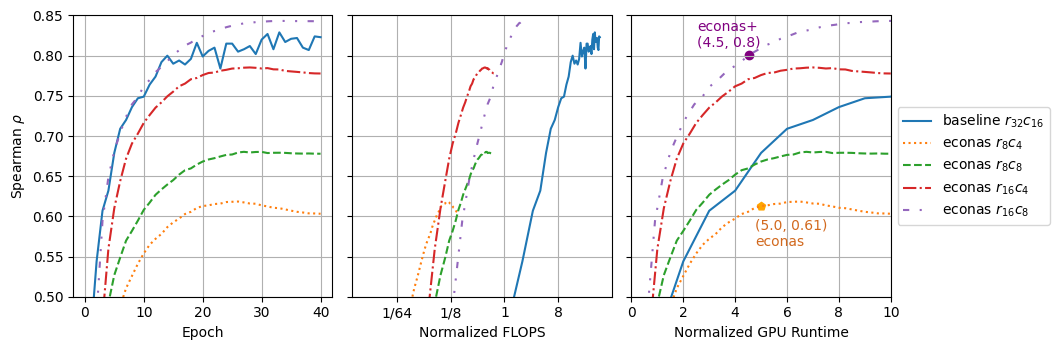

In [50]:
with open('../results_release/nasbench2/nb2_fast_train.p','rb') as f:
    truns = pickle.load(f)
    
per_epochs=[]
for expname in ['nb2_fast_train', 'nb2_fast_train_ch8', 'nb2_fast_train_im16', 'nb2_fast_train_im16_ch8']:

    with open(f'../results_release/nasbench2/{expname}.p','rb') as f:
        truns = pickle.load(f)

    #form array per epoch for fast training
    per_epoch = {}
    for r in truns:
        for i,e in enumerate(r['logmeasures']):
            if i not in per_epoch:
                per_epoch[i] = []
            per_epoch[i].append(e['val_acc'])
    per_epochs.append(per_epoch)
    
ds = 'cifar10'
econas = []
acc = dallb[ds][0]
for exp in per_epochs:
    l = []
    t = PrettyTable(['Epoch', 'Correlation of Proxy Training'])
    for k,b in exp.items():
        r = [k]
        cr = abs(stats.spearmanr(b,acc,nan_policy='omit').correlation)
        r.append(round(cr,3))
        t.add_row(r)
        l.append(cr)
    econas.append(l)

#WE ONLY IMPLEMENT ECONAS FOR CIFAR10

ls = ['solid','dotted','dashed','dashdot',(0, (3, 5, 1, 5, 1, 5))]

ds = 'cifar10'
slow=dslow[ds]
fig, axs = plt.subplots(1,3,figsize=(10.7,3.6), sharey=True)

ax=axs[0]

epx=41

#regular training
x=range(0,epx,1)
ax.plot(x,slow[0:epx], label= 'baseline $r_{32}c_{16}$', linestyle=ls[0])

#econas
x2=range(0,epx,1)
ax.plot(x2,econas[0][0:epx], label='econas $r_8c_4$', linestyle=ls[1])
ax.plot(x2,econas[1][0:epx], label='econas $r_8c_8$', linestyle=ls[2])
ax.plot(x2,econas[2][0:epx], label='econas $r_{16}c_4$', linestyle=ls[3])
ax.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4])
ax.grid()
ax.set_ylim(0.5,0.85)
ax.set_xlabel("Epoch")
ax.set_ylabel('Spearman $\\rho$')

#--------------------------------------------------------------------------------
ax=axs[1]

#regular training
x=[ff for ff in range(0,epx)]
ax.plot(x,slow[0:epx], label= 'baseline $r_{32}c_{16}$', linestyle=ls[0])

#econas
d = 230
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[0][0:epx], label='econas $r_8c_4$', linestyle=ls[1])
d = 59.5
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[1][0:epx], label='econas $r_8c_8$', linestyle=ls[2])
ax.plot(x2,econas[2][0:epx], label='econas $r_{16}c_4$', linestyle=ls[3])
d = 15.4
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4])

ax.grid()
ax.set_ylim(0.5,0.85)
#plt.xlim(0,0.01)
ax.set_xlabel("Normalized FLOPS")
ax.set_xscale('log', base=2)

from fractions import Fraction
labels = ("1", "1", '1/64', "1/8", "1", "8")
ax.set_xticklabels(labels)

#--------------------------------------------------------------------------------
ax=axs[2]

#regular training
x=[ff for ff in range(0,epx)]
ax.plot(x,slow[0:epx], label= 'baseline $r_{32}c_{16}$', linestyle=ls[0])

#econas
d = 4
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[0][0:epx], label='econas $r_8c_4$', linestyle=ls[1])
d = 4
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[1][0:epx], label='econas $r_8c_8$', linestyle=ls[2])
ax.plot(x2,econas[2][0:epx], label='econas $r_{16}c_4$', linestyle=ls[3])
d = 3.3
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4])

p=15
ax.scatter(p/d, econas[3][p], marker='o', color='purple')
ax.annotate(f'({round(p/d,1)}, {round(econas[3][p],2)})',(p/d-2, econas[3][p]+0.01), horizontalalignment='left', color='purple')
ax.annotate(f'econas+',(p/d-2, econas[3][p]+0.03), horizontalalignment='left', color='purple')

p=20
ax.scatter(p/4, econas[0][p], marker='p', color='orange')
ax.annotate(f'({round(p/4,1)}, {round(econas[0][p],2)})',(p/d-1.3, econas[0][p]-0.03), horizontalalignment='left', color='chocolate')
ax.annotate(f'econas',(p/d-1.3, econas[0][p]-0.05), horizontalalignment='left', color='chocolate')

ax.grid()
ax.set_ylim(0.5,0.85)
ax.set_xlim(0,10)
ax.set_xlabel("Normalized GPU Runtime")
#ax.set_xscale('log', basex=10)

fig.tight_layout(pad=0.3)
plt.legend(bbox_to_anchor=(1,0.7))
plt.tight_layout()
plt.savefig('econas.pdf')
plt.show()

In [51]:
t

Epoch,Correlation of Proxy Training
0,0.006
1,0.244
2,0.477
3,0.594
4,0.649
5,0.681
6,0.704
7,0.724
8,0.739
9,0.749


In [58]:
allc

{'CIFAR10': {'grad_norm': 0.5948249793871436,
  'snip': 0.5962625788142379,
  'grasp': 0.5187207167554263,
  'fisher': 0.36129414841520346,
  'synflow': 0.1610951703133213,
  'jacob_cov': 0.7281629701964283}}

cifar10


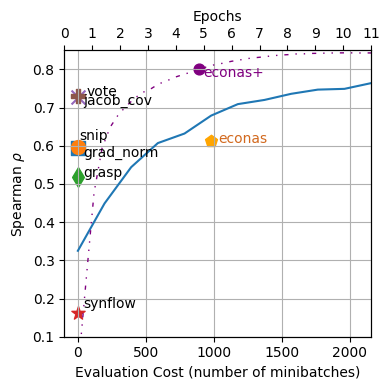

In [63]:
import itertools
sh={
    'cifar10':{
        'jacob_cov':(40,-.02),
        'synflow':(40,.015),
        'snip':(10,.02),
        'grad_norm':(40,-.025),
        'grasp':(40,.0),
        'vote':(60,.0)
    },
    'cifar100':{
        'jacob_cov':(40,.0),
        'synflow':(40,.0),
        'snip':(35,-.02),
        'grad_norm':(35,.02),
        'grasp':(35,.0),
        'vote':(60,.0)
    },
    'ImageNet16-120':{
        'jacob_cov':(40,.0),
        'synflow':(40,.0),
        'snip':(40,.02),
        'grad_norm':(40,-.01),
        'grasp':(40,-.03),
        'vote':(60,.0)
    },
}
markers = {'synflow':'*','jacob_cov':'x','snip':'o','grad_norm':'s','fisher':'+','grasp':'d', 'vote':'P'}
for ds,slow in dslow.items():
    plt.figure(figsize=(4,4))
    x=range(0,196*41,196)
    plt.plot(x,slow)
    for k,v in allc[ds.upper() if 'cifar' in ds else ds].items():
#         if v < 0.4:
#             continue
        if k=='fisher':
            continue
        plt.scatter(1,v, marker=markers[k], s=100)
        plt.text(1+sh[ds][k][0],v+sh[ds][k][1],f'{k}',horizontalalignment='left')
    
    
    k='vote'
    v = votes[ds]
    plt.scatter(3,v, marker=markers['vote'], s=100)
    plt.text(1+sh[ds][k][0],v+sh[ds][k][1],f'{k}',horizontalalignment='left')
    
    if ds == 'cifar10':
        x2 = [c/3.3 for c in x]
        plt.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4], color='purple', linewidth=1)
        p=15
        plt.scatter(p*196/d, econas[3][p], marker='o', color='purple', s=60)
        plt.annotate('econas+',(p*196/d+30, econas[3][p]-0.02), horizontalalignment='left', color='purple')
        x3 = [c/4 for c in x]
        p=20
        plt.scatter(p*196/4, econas[0][p], marker='p', color='orange', s=80)
        plt.annotate(f'econas',(p*196/4+50, econas[0][p]-0.005), horizontalalignment='left', color='chocolate')

    
    #plt.legend()
    plt.grid()

    ax1 = plt.gca()
    ax1.set_xlim(-100,196*11)
    ax1.set_ylim(0.1,0.85)
    ax2 = ax1.twiny()
    ax2.set_xticks(range(0,12))
    ax1.set_xlabel("Evaluation Cost (number of minibatches)")
    ax2.set_xlabel("Epochs")

    ax1.set_ylabel('Spearman $\\rho$')
    #plt.xscale('log')
    print(ds)
    plt.tight_layout()
    #plt.savefig(f'nb2'+(ds if 'cifar' in ds else 'im16')+'.pdf')
    plt.show()